the below code equally partitions no tumor and then sets alpha as 1



In [1]:
import os
import random
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset, random_split


# ---- CONFIG ----
ROOT = "/Users/ishabhansali/Downloads/resnet_project/cleaned"
TRAIN_DIR = os.path.join(ROOT, "Training")
TEST_DIR = os.path.join(ROOT, "Testing")
NUM_CLIENTS = 4
LOCAL_TEST_FRAC = 0.2
SEED = 77
ALPHA = 1.0  # Moderate non-IID
BATCH_SIZE_MOD = 32

def set_seed(s=SEED):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# ---- PATH CHECKS ----
if not os.path.exists(ROOT):
    raise FileNotFoundError(f"ROOT folder not found: {ROOT}")
if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"Training directory not found: {TRAIN_DIR}")
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Testing directory not found: {TEST_DIR}")

# ---- TRANSFORM AND LOAD ----
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

print("Creating global holdout (test) loader for moderate non-IID setup...")
holdout_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_MOD,
    shuffle=False,
    num_workers=0
)
print("Global holdout samples:", len(test_dataset))

# ---- MODERATE NON-IID PARTITION (DIRICHLET) ----
labels = np.array([sample[1] for sample in train_dataset])
num_classes = len(train_dataset.classes)
class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

client_indices = [[] for _ in range(NUM_CLIENTS)]
np.random.seed(SEED)

for c, idxs in enumerate(class_indices):
    # Sample proportions for each client using Dirichlet
    proportions = np.random.dirichlet(np.repeat(ALPHA, NUM_CLIENTS))
    # Adjust for rounding errors
    proportions = (np.cumsum(proportions) * len(idxs)).astype(int)[:-1]
    split_idxs = np.split(np.random.permutation(idxs), proportions)
    for client, idx in enumerate(split_idxs):
        client_indices[client].extend(idx)

# Shuffle indices for each client, then create subsets
client_subsets = []
for indices in client_indices:
    indices = np.array(indices)
    np.random.shuffle(indices)
    subset = torch.utils.data.Subset(train_dataset, indices.tolist())
    client_subsets.append(subset)
    print(f"Client {len(client_subsets)-1} train samples: {len(subset)}")

# ---- TEST SPLIT FOR EACH CLIENT ----
client_data = []
for c in client_subsets:
    n_test = int(len(c) * LOCAL_TEST_FRAC)
    n_train = len(c) - n_test
    tr, te = random_split(c, [n_train, n_test], generator=torch.Generator().manual_seed(SEED))
    client_data.append((tr, te))
    print(f"Client train: {n_train}, test: {n_test}")

# ---- CLASS BREAKDOWN FOR EACH CLIENT ----
class_names = train_dataset.classes
for idx, (client_train, _) in enumerate(client_data):
    labels = [client_train[i][1] for i in range(len(client_train))]
    counts = {class_name: labels.count(i) for i, class_name in enumerate(class_names)}
    print(f"Client {idx}:")
    for class_name in class_names:
        print(f"  {class_name}: {counts[class_name]} samples")
    print("-" * 30)
for idx, (client_train, client_test) in enumerate(client_data):
    # Train split breakdown
    train_labels = [client_train[i][1] for i in range(len(client_train))]
    train_counts = {class_name: train_labels.count(i) for i, class_name in enumerate(class_names)}

    # Test split breakdown
    test_labels = [client_test[i][1] for i in range(len(client_test))]
    test_counts = {class_name: test_labels.count(i) for i, class_name in enumerate(class_names)}

    print(f"Client {idx}:")
    print("  Training set:")
    for class_name in class_names:
        print(f"    {class_name}: {train_counts[class_name]} samples")
    print("  Testing set:")
    for class_name in class_names:
        print(f"    {class_name}: {test_counts[class_name]} samples")
    print("-" * 30)



Train samples: 5712, Test samples: 1311
Creating global holdout (test) loader for moderate non-IID setup...
Global holdout samples: 1311
Client 0 train samples: 1990
Client 1 train samples: 1307
Client 2 train samples: 812
Client 3 train samples: 1603
Client train: 1592, test: 398
Client train: 1046, test: 261
Client train: 650, test: 162
Client train: 1283, test: 320
Client 0:
  glioma: 526 samples
  meningioma: 54 samples
  notumor: 824 samples
  pituitary: 188 samples
------------------------------
Client 1:
  glioma: 206 samples
  meningioma: 485 samples
  notumor: 229 samples
  pituitary: 126 samples
------------------------------
Client 2:
  glioma: 297 samples
  meningioma: 105 samples
  notumor: 165 samples
  pituitary: 83 samples
------------------------------
Client 3:
  glioma: 29 samples
  meningioma: 416 samples
  notumor: 54 samples
  pituitary: 784 samples
------------------------------
Client 0:
  Training set:
    glioma: 526 samples
    meningioma: 54 samples
    notu

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(client_subsets, class_names, alpha_value):
    num_clients = len(client_subsets)
    num_classes = len(class_names)

    # Count per-class samples for each client
    dist_matrix = np.zeros((num_clients, num_classes), dtype=int)

    for client_id, subset in enumerate(client_subsets):
        labels = [subset[i][1] for i in range(len(subset))]
        for cls in range(num_classes):
            dist_matrix[client_id, cls] = labels.count(cls)

    # ----------- Plot Bar Chart -----------
    x = np.arange(num_clients)
    width = 0.2   # width of each bar

    plt.figure(figsize=(10,5))
    
    for cls in range(num_classes):
        plt.bar(x + cls*width, dist_matrix[:, cls], width, label=class_names[cls])

    plt.xticks(x + width, [f"client_{i}" for i in range(num_clients)])
    plt.ylabel("Number of Images")
    plt.title(f"Class Distribution (Dirichlet α = {alpha_value})")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.show()

    return dist_matrix


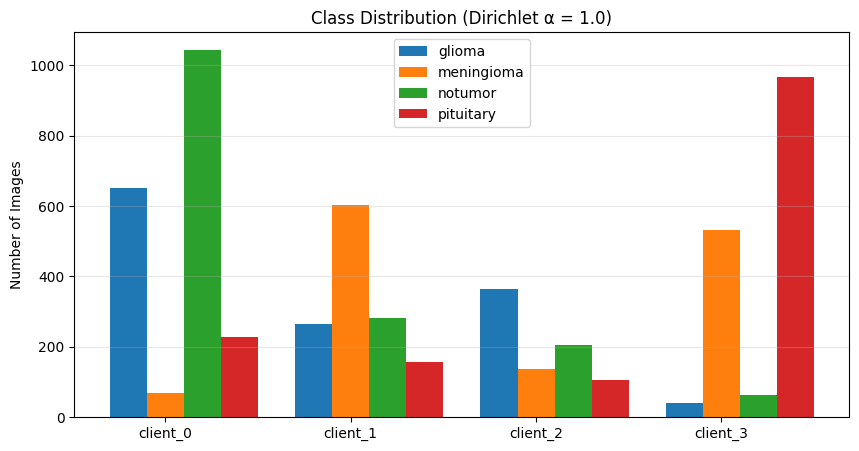

In [3]:
dist_mod = plot_class_distribution(client_subsets, class_names, alpha_value=1.0)


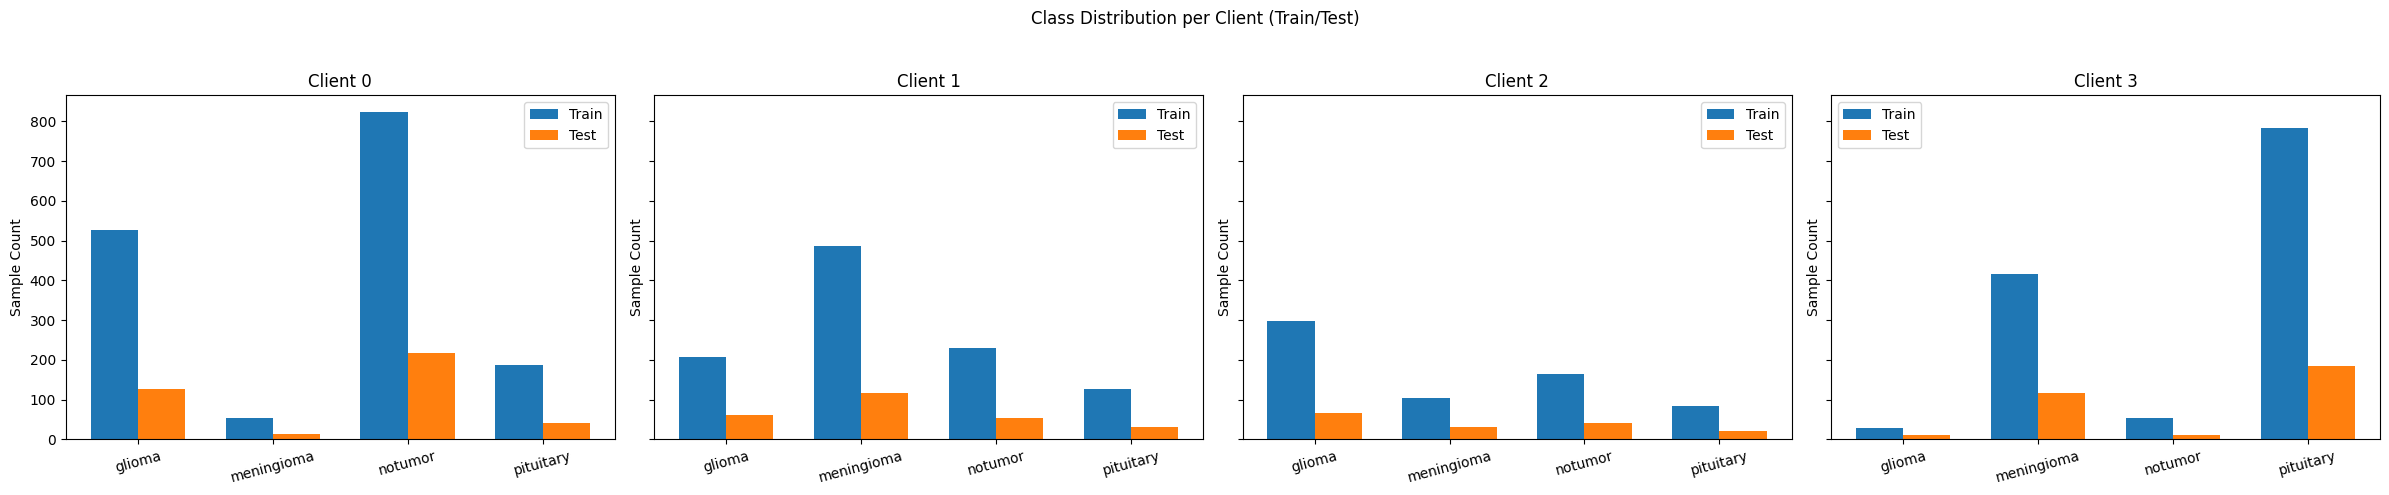

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# ---- PREPARE DATA FOR PLOTTING ----
client_train_counts = []
client_test_counts = []

for idx, (client_train, client_test) in enumerate(client_data):
    train_labels = [client_train[i][1] for i in range(len(client_train))]
    test_labels = [client_test[i][1] for i in range(len(client_test))]
    train_counts = [train_labels.count(i) for i in range(len(class_names))]
    test_counts = [test_labels.count(i) for i in range(len(class_names))]
    client_train_counts.append(train_counts)
    client_test_counts.append(test_counts)

client_train_counts = np.array(client_train_counts)
client_test_counts = np.array(client_test_counts)

# ---- GROUPED BAR CHART FOR EACH CLIENT ----
num_classes = len(class_names)
num_clients = len(client_data)
x = np.arange(num_classes)  # the label locations

fig, axs = plt.subplots(1, num_clients, figsize=(6 * num_clients, 5), sharey=True)
# Each subplot is for one client
for idx in range(num_clients):
    width = 0.35
    axs[idx].bar(x - width/2, client_train_counts[idx], width, label='Train', color='tab:blue')
    axs[idx].bar(x + width/2, client_test_counts[idx], width, label='Test', color='tab:orange')
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(class_names, rotation=15)
    axs[idx].set_ylabel('Sample Count')
    axs[idx].set_title(f'Client {idx}')
    axs[idx].legend()

plt.suptitle('Class Distribution per Client (Train/Test)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


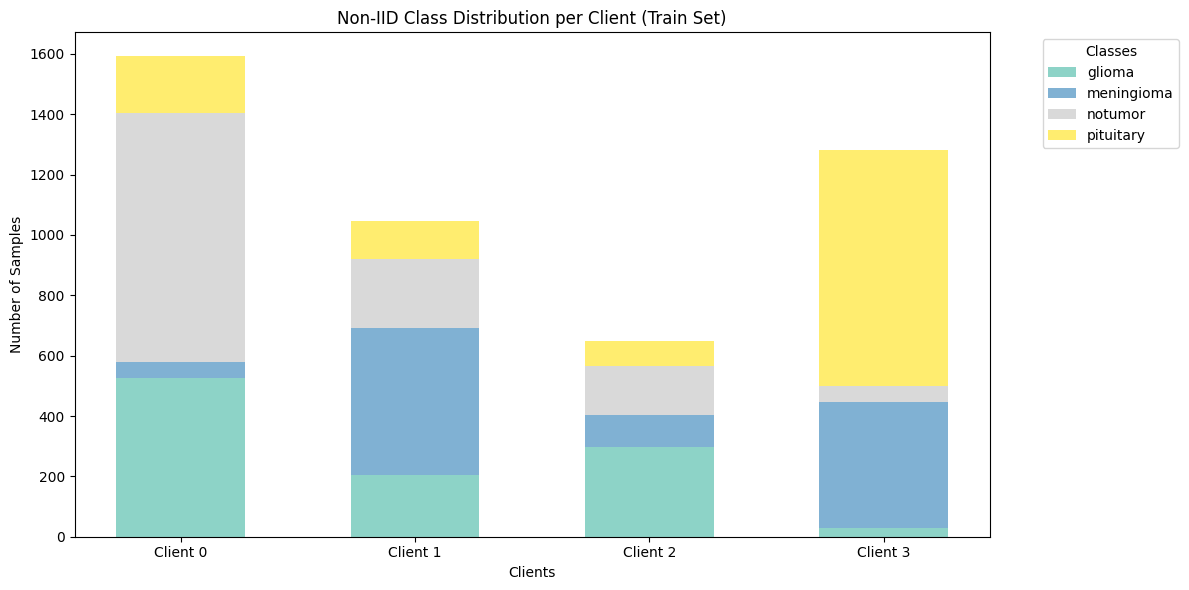

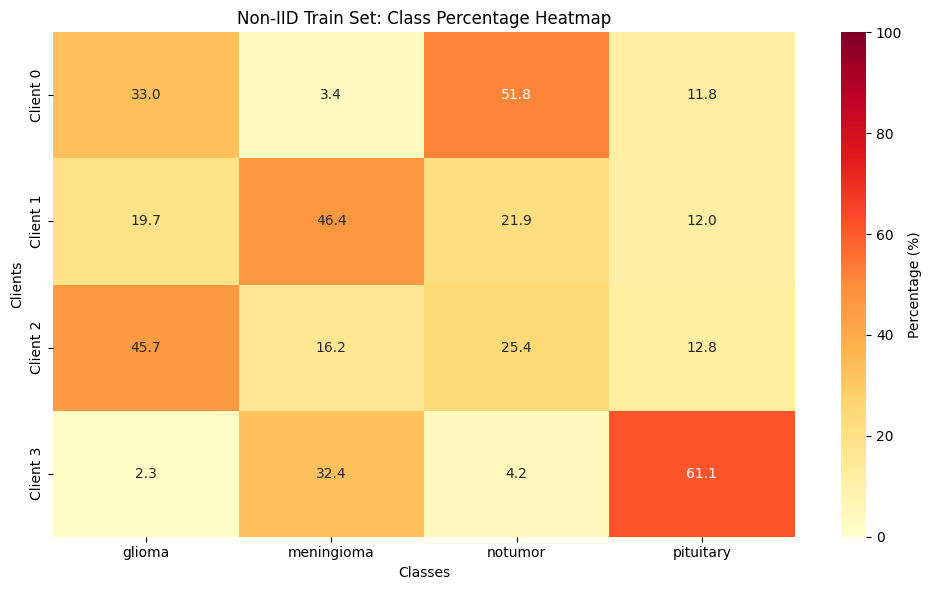

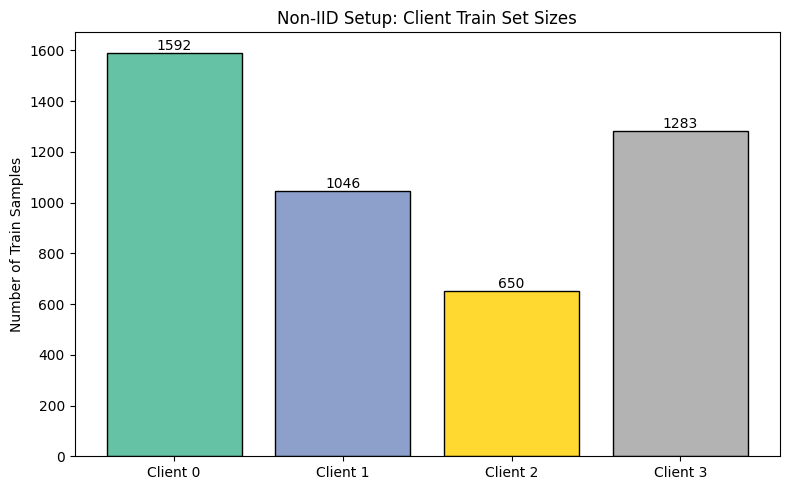

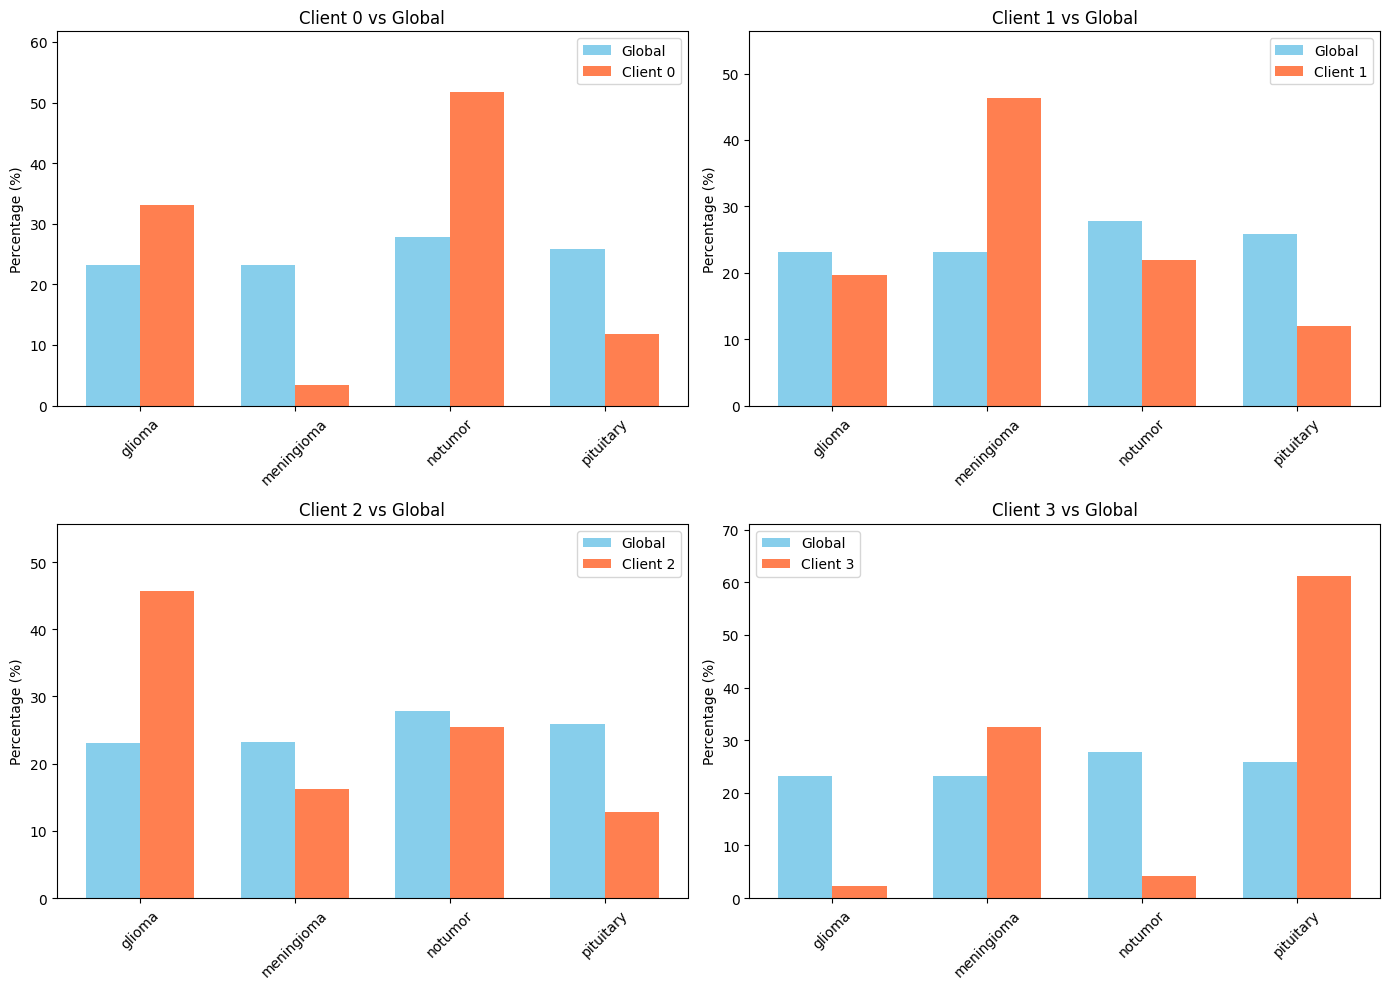


NON-IID DATA DISTRIBUTION SUMMARY (Train)

Client 0: 1592 samples
  glioma: 526 (33.0%)
  meningioma: 54 (3.4%)
  notumor: 824 (51.8%)
  pituitary: 188 (11.8%)

Client 1: 1046 samples
  glioma: 206 (19.7%)
  meningioma: 485 (46.4%)
  notumor: 229 (21.9%)
  pituitary: 126 (12.0%)

Client 2: 650 samples
  glioma: 297 (45.7%)
  meningioma: 105 (16.2%)
  notumor: 165 (25.4%)
  pituitary: 83 (12.8%)

Client 3: 1283 samples
  glioma: 29 (2.3%)
  meningioma: 416 (32.4%)
  notumor: 54 (4.2%)
  pituitary: 784 (61.1%)

Global Distribution (Train Set):
  glioma: 1058 (23.1%)
  meningioma: 1060 (23.2%)
  notumor: 1272 (27.8%)
  pituitary: 1181 (25.8%)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

# ----- 1. Collect train set class counts for each client -----
client_class_dist = []
for client_train, _ in client_data:  # only train split
    labels = [client_train[i][1] for i in range(len(client_train))]
    counts = [labels.count(i) for i in range(len(class_names))]
    client_class_dist.append(counts)

num_clients = len(client_class_dist)
num_classes = len(class_names)

# ----- 2. Stacked bar chart: class samples per client -----
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(num_clients)
bottom = np.zeros(num_clients)
colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

for class_idx in range(num_classes):
    values = [client_class_dist[cidx][class_idx] for cidx in range(num_clients)]
    ax.bar(x, values, bottom=bottom, width=0.55, color=colors[class_idx], label=class_names[class_idx])
    bottom += np.array(values)
ax.set_xticks(x)
ax.set_xticklabels([f"Client {i}" for i in range(num_clients)])
ax.set_ylabel("Number of Samples")
ax.set_xlabel("Clients")
ax.set_title("Non-IID Class Distribution per Client (Train Set)")
ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ----- 3. Heatmap: class percentage per client -----
heatmap_data = []
for counts in client_class_dist:
    total = sum(counts)
    row = [100 * c / total if total > 0 else 0 for c in counts]
    heatmap_data.append(row)
heatmap_data = np.array(heatmap_data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Percentage (%)'},
            xticklabels=class_names, yticklabels=[f"Client {i}" for i in range(num_clients)], ax=ax, vmin=0, vmax=100)
ax.set_title("Non-IID Train Set: Class Percentage Heatmap")
ax.set_xlabel("Classes")
ax.set_ylabel("Clients")
plt.tight_layout()
plt.show()

# ----- 4. Bar chart: client train set sizes -----
client_sizes = [sum(counts) for counts in client_class_dist]
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar([f"Client {i}" for i in range(num_clients)], client_sizes, color=plt.cm.Set2(np.linspace(0,1,num_clients)), edgecolor='black')
ax.set_ylabel("Number of Train Samples")
ax.set_title("Non-IID Setup: Client Train Set Sizes")
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# ----- 5. Comparison: global distribution vs client -----
global_counts = [0 for _ in range(num_classes)]
for client_train, _ in client_data:
    labels = [client_train[i][1] for i in range(len(client_train))]
    for i in labels:
        global_counts[i] += 1
global_total = sum(global_counts)
global_percentages = [100 * c / global_total for c in global_counts]

fig, axes = plt.subplots(2, (num_clients+1)//2, figsize=(14, 10))
axes = axes.flatten()
for idx in range(num_clients):
    client_total = sum(client_class_dist[idx])
    client_percentages = [100 * n / client_total if client_total > 0 else 0 for n in client_class_dist[idx]]
    x_pos = np.arange(num_classes)
    width = 0.35
    axes[idx].bar(x_pos - width/2, global_percentages, width, label='Global', color='skyblue')
    axes[idx].bar(x_pos + width/2, client_percentages, width, label=f'Client {idx}', color='coral')
    axes[idx].set_title(f"Client {idx} vs Global")
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(class_names, rotation=45)
    axes[idx].set_ylabel("Percentage (%)")
    axes[idx].legend()
    axes[idx].set_ylim([0, max(global_percentages + client_percentages) + 10])
plt.tight_layout()
plt.show()

# ----- 6. Summary statistics -----
print("\n" + "="*50)
print("NON-IID DATA DISTRIBUTION SUMMARY (Train)")
print("="*50)
for idx, counts in enumerate(client_class_dist):
    client_total = sum(counts)
    print(f"\nClient {idx}: {client_total} samples")
    for class_idx, class_name in enumerate(class_names):
        pct = 100 * counts[class_idx] / client_total if client_total > 0 else 0
        print(f"  {class_name}: {counts[class_idx]} ({pct:.1f}%)")

print("\n" + "="*50)
print("Global Distribution (Train Set):")
print("="*50)
for class_idx, class_name in enumerate(class_names):
    pct = 100 * global_counts[class_idx] / global_total if global_total > 0 else 0
    print(f"  {class_name}: {global_counts[class_idx]} ({pct:.1f}%)")
print("="*50)


In [5]:
import numpy as np
from scipy.spatial.distance import jensenshannon

# ----- 1. Prepare class distributions -----

# Get number of classes
num_classes = len(train_dataset.classes)

# Extract class distributions for each client
client_distributions = []
for k in range(NUM_CLIENTS):
    idxs = client_indices[k]
    counts = np.zeros(num_classes)
    for i in idxs:
        class_idx = train_dataset.samples[i][1]  # (filename, class_idx)
        counts[class_idx] += 1
    # Normalize to probabilities
    if counts.sum() > 0:
        prob_vec = counts / counts.sum()
    else:
        prob_vec = counts
    client_distributions.append(prob_vec)

# ----- 2. Compute global class distribution -----
global_counts = np.zeros(num_classes)
for sample in train_dataset.samples:
    class_idx = sample[1]
    global_counts[class_idx] += 1
global_dist = global_counts / global_counts.sum()

print("Global Distribution:", global_dist)
print("Classes:", train_dataset.classes)

# ----- 3. Compute Jensen-Shannon Divergence (JS Divergence) -----
print("\n" + "="*70)
print("JENSEN-SHANNON DIVERGENCE (Client vs Global)")
print("="*70)
print("Range: 0 (identical) to 1 (completely different)\n")

js_divergences = []
for k, client_dist in enumerate(client_distributions):
    js_div = jensenshannon(global_dist, client_dist)
    js_divergences.append(js_div)
    print(f"Client {k}: JS Divergence = {js_div:.4f}")

avg_js = np.mean(js_divergences)
print(f"\nAverage JS Divergence: {avg_js:.4f}")


Global Distribution: [0.23126751 0.23441877 0.27923669 0.25507703]
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

JENSEN-SHANNON DIVERGENCE (Client vs Global)
Range: 0 (identical) to 1 (completely different)

Client 0: JS Divergence = 0.2805
Client 1: JS Divergence = 0.1837
Client 2: JS Divergence = 0.1764
Client 3: JS Divergence = 0.3735

Average JS Divergence: 0.2535


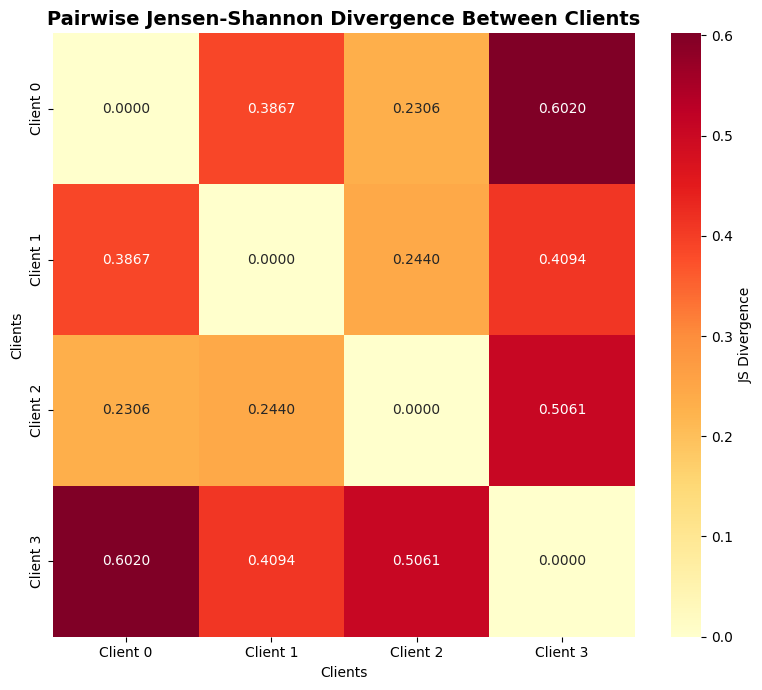

In [7]:
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns

# ----- 1. Prepare client class probability distributions -----
num_classes = len(train_dataset.classes)
client_distributions = []
for k in range(NUM_CLIENTS):
    idxs = client_indices[k]
    counts = np.zeros(num_classes)
    for i in idxs:
        class_idx = train_dataset.samples[i][1]
        counts[class_idx] += 1
    prob_vec = counts / counts.sum() if counts.sum() > 0 else counts
    client_distributions.append(prob_vec)

# ----- 2. Compute pairwise JS divergence matrix -----
pairwise_js = np.zeros((NUM_CLIENTS, NUM_CLIENTS))
for i in range(NUM_CLIENTS):
    for j in range(NUM_CLIENTS):
        pairwise_js[i, j] = jensenshannon(client_distributions[i], client_distributions[j])

# ----- 3. Plot pairwise JS divergence heatmap -----
plt.figure(figsize=(8, 7))
sns.heatmap(pairwise_js, annot=True, fmt='.4f', cmap='YlOrRd',
            xticklabels=[f'Client {i}' for i in range(NUM_CLIENTS)],
            yticklabels=[f'Client {i}' for i in range(NUM_CLIENTS)],
            cbar_kws={'label': 'JS Divergence'})
plt.title('Pairwise Jensen-Shannon Divergence Between Clients', fontsize=14, fontweight='bold')
plt.xlabel('Clients')
plt.ylabel('Clients')
plt.tight_layout()
plt.show()


In [8]:
# ============================================================
#        FEDAVG (MODERATE NON-IID) — PRETRAINED RESNET18
# ============================================================

import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader


# ============================================================
#                    DEVICE SETUP
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 Using NVIDIA GPU (CUDA)")
else:
    DEVICE = torch.device("cpu")
    print("🖥 Using CPU")


# ============================================================
#          CONFIG (MODERATE NON-IID FEDAVG — PRETRAINED)
# ============================================================
SEED = 77
NUM_ROUNDS_MOD = 30
LOCAL_EPOCHS_MOD = 5
LR_MOD = 3e-4
BATCH_SIZE_MOD = 32

NUM_CLIENTS_MOD = len(client_data)      # list of (train_subset, test_subset)
NUM_CLASSES_MOD = len(train_dataset.classes)

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

crit_ce = nn.CrossEntropyLoss()


# ============================================================
#     PRETRAINED RESNET18 WITH FREEZING STRATEGY
# ============================================================
def create_pretrained_resnet18_mod(num_classes):

    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze low layers
    for p in model.conv1.parameters(): p.requires_grad = False
    for p in model.bn1.parameters(): p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    # Train deeper layers
    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    # Replace FC head
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)

    return model


# ============================================================
#                TRAINING + EVALUATION
# ============================================================
def train_one_epoch_mod(model, loader, device, optimizer):
    model.train()
    tot_loss = tot_corr = tot = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = crit_ce(logits, y)
        loss.backward()
        optimizer.step()

        tot_loss += loss.item() * x.size(0)
        tot_corr += (logits.argmax(1) == y).sum().item()
        tot += x.size(0)

    return {"loss": tot_loss / tot, "acc": tot_corr / tot}


@torch.no_grad()
def evaluate_mod(model, loader, device):
    model.eval()
    tot_loss = tot_corr = tot = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = crit_ce(logits, y)

        tot_loss += loss.item() * x.size(0)
        tot_corr += (logits.argmax(1) == y).sum().item()
        tot += x.size(0)

    return {"loss": tot_loss / tot, "acc": tot_corr / tot}


# ============================================================
#        BUILD CLIENT TRAIN + TEST LOADERS
# ============================================================
client_train_loaders_mod = []
client_test_loaders_mod = []

for train_subset, test_subset in client_data:
    client_train_loaders_mod.append(
        DataLoader(train_subset, batch_size=BATCH_SIZE_MOD, shuffle=True)
    )
    client_test_loaders_mod.append(
        DataLoader(test_subset, batch_size=BATCH_SIZE_MOD, shuffle=False)
    )


# ============================================================
#        GLOBAL MODEL INITIALIZATION
# ============================================================
global_model_mod = create_pretrained_resnet18_mod(NUM_CLASSES_MOD).to(DEVICE)

best_acc_mod = -1.0
best_state_mod = None

metrics_history_fedavg_moderate_pretrained = {
    "round": [],
    "holdout": [],
    "clients": {k: [] for k in range(NUM_CLIENTS_MOD)}
}


# ============================================================
#                     FEDAVG TRAINING LOOP
# ============================================================
for rnd in range(NUM_ROUNDS_MOD):

    print(f"\n🔁 [MODERATE] FedAvg Pretrained Round {rnd+1}/{NUM_ROUNDS_MOD}")

    local_states = []

    # ----- CLIENT TRAINING -----
    for k in range(NUM_CLIENTS_MOD):

        local_model = copy.deepcopy(global_model_mod).to(DEVICE)

        optimizer = optim.Adam(
            (p for p in local_model.parameters() if p.requires_grad),
            lr=LR_MOD
        )

        for ep in range(LOCAL_EPOCHS_MOD):
            train_one_epoch_mod(local_model, client_train_loaders_mod[k], DEVICE, optimizer)

        # Save model params
        local_states.append({
            name: param.cpu() for name, param in local_model.state_dict().items()
        })

        # Per-client evaluation
        client_metric = evaluate_mod(local_model, client_test_loaders_mod[k], DEVICE)
        metrics_history_fedavg_moderate_pretrained["clients"][k].append(client_metric)

        print(f"  Client {k} | Acc: {client_metric['acc']:.4f}")


    # ----- FEDAVG AGGREGATION -----
    new_state = {}
    for key in global_model_mod.state_dict().keys():
        stacked = torch.stack([state[key] for state in local_states], dim=0)

        if stacked.dtype.is_floating_point:
            new_state[key] = stacked.mean(dim=0)
        else:
            new_state[key] = stacked[0]

    global_model_mod.load_state_dict(new_state)


    # ----- GLOBAL HOLDOUT EVAL -----
    holdout_metric = evaluate_mod(global_model_mod, holdout_loader, DEVICE)

    metrics_history_fedavg_moderate_pretrained["round"].append(rnd + 1)
    metrics_history_fedavg_moderate_pretrained["holdout"].append(holdout_metric)

    print(f"🌍 Global Holdout | Acc: {holdout_metric['acc']:.4f}, Loss: {holdout_metric['loss']:.4f}")


    # ----- SAVE BEST -----
    if holdout_metric["acc"] > best_acc_mod:
        best_acc_mod = holdout_metric["acc"]
        best_state_mod = copy.deepcopy(global_model_mod.state_dict())
        print(f"💾 New BEST Model Saved! Acc = {best_acc_mod:.4f}")


# ============================================================
#                   SAVE OUTPUTS
# ============================================================
torch.save(best_state_mod, "best_fedavg_moderate_pretrained.pth")
np.save("metrics_history_fedavg_moderate_pretrained.npy",
        metrics_history_fedavg_moderate_pretrained)

print("\n✅ Saved:")
print("   • best_fedavg_moderate_pretrained.pth")
print("   • metrics_history_fedavg_moderate_pretrained.npy")


🚀 Using Apple Silicon GPU (MPS)

🔁 [MODERATE] FedAvg Pretrained Round 1/30
  Client 0 | Acc: 0.9724
  Client 1 | Acc: 0.9272
  Client 2 | Acc: 0.8765
  Client 3 | Acc: 0.9563
🌍 Global Holdout | Acc: 0.9260, Loss: 0.1885
💾 New BEST Model Saved! Acc = 0.9260

🔁 [MODERATE] FedAvg Pretrained Round 2/30
  Client 0 | Acc: 0.9749
  Client 1 | Acc: 0.9349
  Client 2 | Acc: 0.9259
  Client 3 | Acc: 0.9625
🌍 Global Holdout | Acc: 0.9573, Loss: 0.1302
💾 New BEST Model Saved! Acc = 0.9573

🔁 [MODERATE] FedAvg Pretrained Round 3/30
  Client 0 | Acc: 0.9749
  Client 1 | Acc: 0.9310
  Client 2 | Acc: 0.9383
  Client 3 | Acc: 0.9688
🌍 Global Holdout | Acc: 0.9680, Loss: 0.1012
💾 New BEST Model Saved! Acc = 0.9680

🔁 [MODERATE] FedAvg Pretrained Round 4/30
  Client 0 | Acc: 0.9698
  Client 1 | Acc: 0.9349
  Client 2 | Acc: 0.9383
  Client 3 | Acc: 0.9688
🌍 Global Holdout | Acc: 0.9641, Loss: 0.1120

🔁 [MODERATE] FedAvg Pretrained Round 5/30
  Client 0 | Acc: 0.9749
  Client 1 | Acc: 0.9387
  Client 2 |

DEVICE = mps
✅ Loaded best FedAvg-Moderate-Pretrained model!

📊 FEDAVG – MODERATE NON-IID (PRETRAINED) – METRICS
Accuracy : 0.9825
Loss     : 0.0790
Precision: 0.9814
Recall   : 0.9812
F1 Score : 0.9813


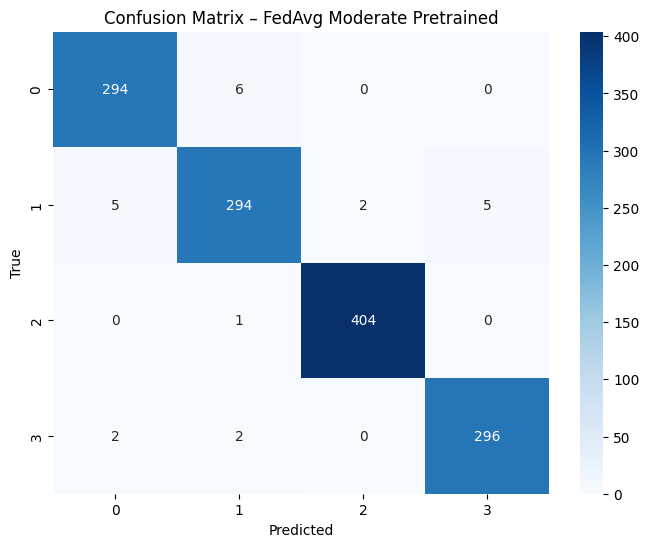

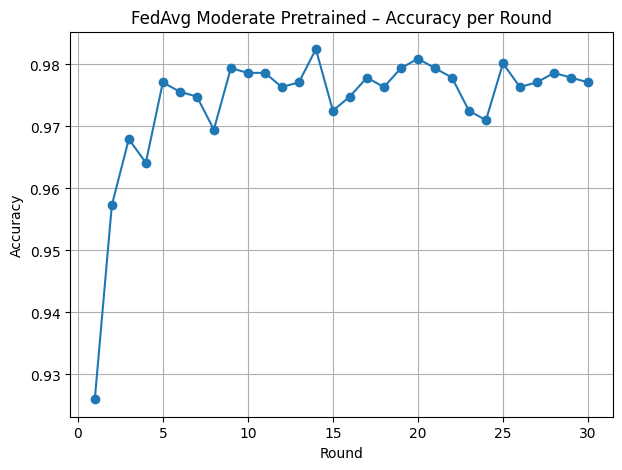

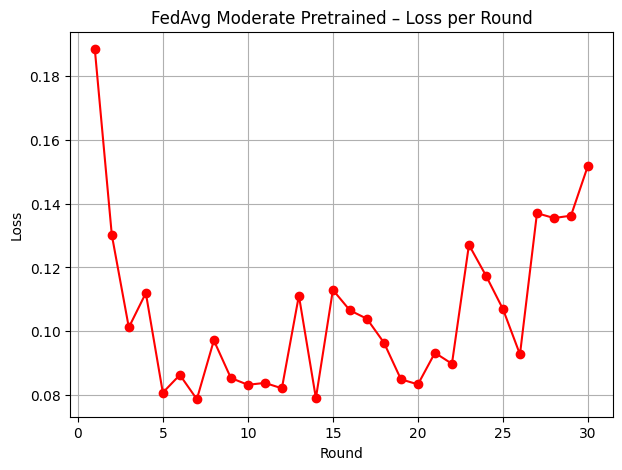

In [11]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
from torchvision import models
import torch.nn as nn

# ============================================================
# DEVICE
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("DEVICE =", DEVICE)

# ============================================================
# MODEL DEF (same freezing strategy as training)
# ============================================================
def create_pretrained_resnet18_mod(num_classes):

    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze low-level layers
    for p in model.conv1.parameters(): p.requires_grad = False
    for p in model.bn1.parameters(): p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    # Train deeper layers
    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    # Replace FC
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)

    return model

# ============================================================
# LOAD MODEL
# ============================================================
NUM_CLASSES_MOD = len(train_dataset.classes)

best_model = create_pretrained_resnet18_mod(NUM_CLASSES_MOD)
best_model.load_state_dict(torch.load("best_fedavg_moderate_pretrained.pth", map_location=DEVICE))
best_model.to(DEVICE)
best_model.eval()

print("✅ Loaded best FedAvg-Moderate-Pretrained model!")

# ============================================================
# EVALUATE ON HOLDOUT SET
# ============================================================
crit_ce = nn.CrossEntropyLoss()

all_preds = []
all_labels = []
total_loss = 0
total = 0

with torch.no_grad():
    for x, y in holdout_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = best_model(x)
        loss = crit_ce(logits, y)

        total_loss += loss.item() * x.size(0)
        total += x.size(0)

        preds = logits.argmax(1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()
loss = total_loss / total

# Metrics
acc = (all_preds == all_labels).mean()
prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)
f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

print("\n📊 FEDAVG – MODERATE NON-IID (PRETRAINED) – METRICS")
print(f"Accuracy : {acc:.4f}")
print(f"Loss     : {loss:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

# ============================================================
# CONFUSION MATRIX
# ============================================================
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – FedAvg Moderate Pretrained")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ============================================================
# LOAD METRICS HISTORY
# ============================================================
history = np.load("metrics_history_fedavg_moderate_pretrained.npy", allow_pickle=True).item()

rounds = history["round"]
accs = [m["acc"] for m in history["holdout"]]
losses = [m["loss"] for m in history["holdout"]]

# ============================================================
# ACCURACY PLOT
# ============================================================
plt.figure(figsize=(7,5))
plt.plot(rounds, accs, marker="o")
plt.title("FedAvg Moderate Pretrained – Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# ============================================================
# LOSS PLOT
# ============================================================
plt.figure(figsize=(7,5))
plt.plot(rounds, losses, marker="o", color="red")
plt.title("FedAvg Moderate Pretrained – Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [12]:
# ============================================================
#        FEDPROX (MODERATE NON-IID) — PRETRAINED RESNET18
# ============================================================

import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader


# ============================================================
#                    DEVICE SETUP
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 Using NVIDIA GPU (CUDA)")
else:
    DEVICE = torch.device("cpu")
    print("🖥 Using CPU")


# ============================================================
#          CONFIG (MODERATE NON-IID FEDPROX — PRETRAINED)
# ============================================================
SEED = 77
NUM_ROUNDS_MOD_FP = 30
LOCAL_EPOCHS_MOD_FP = 5
LR_MOD_FP = 3e-4
BATCH_SIZE_MOD_FP = 32
FEDPROX_MU_MOD = 1e-3  # μ for moderate non-IID

NUM_CLIENTS_MOD = len(client_data)
NUM_CLASSES_MOD = len(train_dataset.classes)

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

crit_ce = nn.CrossEntropyLoss()


# ============================================================
#   PRETRAINED RESNET18 WITH FREEZING (SAME AS FEDAVG)
# ============================================================
def create_pretrained_resnet18_mod_fp(num_classes):

    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze low layers
    for p in model.conv1.parameters(): p.requires_grad = False
    for p in model.bn1.parameters(): p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    # Train deeper layers
    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    # Replace FC head
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)

    return model


# ============================================================
#                 FEDPROX LOCAL TRAINING
# ============================================================
def train_fedprox_epoch_mod(model, loader, device, optimizer, global_params, mu):

    model.train()
    tot_loss = tot_corr = tot = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        ce_loss = crit_ce(logits, y)

        # FedProx proximal term
        prox_term = 0.0
        for name, param in model.named_parameters():
            if param.requires_grad:
                prox_term += ((param - global_params[name]) ** 2).sum()

        loss = ce_loss + (mu / 2.0) * prox_term
        loss.backward()
        optimizer.step()

        tot_loss += loss.item() * x.size(0)
        tot_corr += (logits.argmax(1) == y).sum().item()
        tot += x.size(0)

    return {"loss": tot_loss / tot, "acc": tot_corr / tot}


# ============================================================
#                     EVALUATION
# ============================================================
@torch.no_grad()
def evaluate_mod_fp(model, loader, device):
    model.eval()
    tot_loss = tot_corr = tot = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = crit_ce(logits, y)

        tot_loss += loss.item() * x.size(0)
        tot_corr += (logits.argmax(1) == y).sum().item()
        tot += x.size(0)

    return {"loss": tot_loss / tot, "acc": tot_corr / tot}


# ============================================================
#        CLIENT TRAIN + TEST LOADERS
# ============================================================
client_train_loaders_mod_fp = []
client_test_loaders_mod_fp = []

for train_subset, test_subset in client_data:
    client_train_loaders_mod_fp.append(
        DataLoader(train_subset, batch_size=BATCH_SIZE_MOD_FP, shuffle=True)
    )
    client_test_loaders_mod_fp.append(
        DataLoader(test_subset, batch_size=BATCH_SIZE_MOD_FP, shuffle=False)
    )


# ============================================================
#                 GLOBAL MODEL INIT
# ============================================================
global_model_mod_fp = create_pretrained_resnet18_mod_fp(NUM_CLASSES_MOD).to(DEVICE)

best_acc_mod_fp = -1.0
best_state_mod_fp = None

metrics_history_fedprox_moderate_pretrained = {
    "round": [],
    "holdout": [],
    "clients": {k: [] for k in range(NUM_CLIENTS_MOD)}
}


# ============================================================
#                     FEDPROX TRAINING LOOP
# ============================================================
for rnd in range(NUM_ROUNDS_MOD_FP):

    print(f"\n🔁 [MODERATE] FedProx Pretrained Round {rnd+1}/{NUM_ROUNDS_MOD_FP}")

    local_states = []

    # Cache global parameters for FedProx μ
    global_params = {
        name: p.detach().clone().to(DEVICE)
        for name, p in global_model_mod_fp.named_parameters()
    }

    # --------- CLIENT TRAINING ---------
    for k in range(NUM_CLIENTS_MOD):

        local_model = copy.deepcopy(global_model_mod_fp).to(DEVICE)

        optimizer = optim.Adam(
            (p for p in local_model.parameters() if p.requires_grad),
            lr=LR_MOD_FP
        )

        for ep in range(LOCAL_EPOCHS_MOD_FP):
            train_fedprox_epoch_mod(
                local_model,
                client_train_loaders_mod_fp[k],
                DEVICE,
                optimizer,
                global_params,
                mu=FEDPROX_MU_MOD
            )

        # Save model weights
        local_states.append({
            name: param.cpu() for name, param in local_model.state_dict().items()
        })

        # Per-client eval
        client_metric = evaluate_mod_fp(local_model, client_test_loaders_mod_fp[k], DEVICE)
        metrics_history_fedprox_moderate_pretrained["clients"][k].append(client_metric)

        print(f"  Client {k} | Acc: {client_metric['acc']:.4f}")


    # --------- FEDPROX AGGREGATION ---------
    new_state = {}
    for key in global_model_mod_fp.state_dict().keys():
        stacked = torch.stack([state[key] for state in local_states], dim=0)

        if stacked.dtype.is_floating_point:
            new_state[key] = stacked.mean(dim=0)
        else:
            new_state[key] = stacked[0]

    global_model_mod_fp.load_state_dict(new_state)


    # -------- GLOBAL HOLDOUT --------
    holdout_metric = evaluate_mod_fp(global_model_mod_fp, holdout_loader, DEVICE)

    metrics_history_fedprox_moderate_pretrained["round"].append(rnd + 1)
    metrics_history_fedprox_moderate_pretrained["holdout"].append(holdout_metric)

    print(f"🌍 Global Holdout | Acc: {holdout_metric['acc']:.4f}, Loss: {holdout_metric['loss']:.4f}")


    # -------- SAVE BEST --------
    if holdout_metric["acc"] > best_acc_mod_fp:
        best_acc_mod_fp = holdout_metric["acc"]
        best_state_mod_fp = copy.deepcopy(global_model_mod_fp.state_dict())
        print(f"💾 New BEST FedProx Model Saved! Acc = {best_acc_mod_fp:.4f}")


# ============================================================
#                     SAVE OUTPUTS
# ============================================================
torch.save(best_state_mod_fp, "best_fedprox_moderate_pretrained.pth")
np.save("metrics_history_fedprox_moderate_pretrained.npy",
        metrics_history_fedprox_moderate_pretrained)

print("\n✅ Saved:")
print("   • best_fedprox_moderate_pretrained.pth")
print("   • metrics_history_fedprox_moderate_pretrained.npy")


🚀 Using Apple Silicon GPU (MPS)

🔁 [MODERATE] FedProx Pretrained Round 1/30
  Client 0 | Acc: 0.9774
  Client 1 | Acc: 0.9272
  Client 2 | Acc: 0.8889
  Client 3 | Acc: 0.9437
🌍 Global Holdout | Acc: 0.9329, Loss: 0.1886
💾 New BEST FedProx Model Saved! Acc = 0.9329

🔁 [MODERATE] FedProx Pretrained Round 2/30
  Client 0 | Acc: 0.9749
  Client 1 | Acc: 0.9425
  Client 2 | Acc: 0.9259
  Client 3 | Acc: 0.9625
🌍 Global Holdout | Acc: 0.9558, Loss: 0.1322
💾 New BEST FedProx Model Saved! Acc = 0.9558

🔁 [MODERATE] FedProx Pretrained Round 3/30
  Client 0 | Acc: 0.9673
  Client 1 | Acc: 0.8659
  Client 2 | Acc: 0.9506
  Client 3 | Acc: 0.9719
🌍 Global Holdout | Acc: 0.9703, Loss: 0.0809
💾 New BEST FedProx Model Saved! Acc = 0.9703

🔁 [MODERATE] FedProx Pretrained Round 4/30
  Client 0 | Acc: 0.9824
  Client 1 | Acc: 0.9425
  Client 2 | Acc: 0.9198
  Client 3 | Acc: 0.9719
🌍 Global Holdout | Acc: 0.9680, Loss: 0.0895

🔁 [MODERATE] FedProx Pretrained Round 5/30
  Client 0 | Acc: 0.9774
  Client

DEVICE = mps
✅ Loaded: best_fedprox_moderate_pretrained.pth

📊 FEDPROX — MODERATE NON-IID (PRETRAINED) METRICS
Accuracy : 0.9847
Loss     : 0.0725
Precision: 0.9840
Recall   : 0.9835
F1 Score : 0.9838


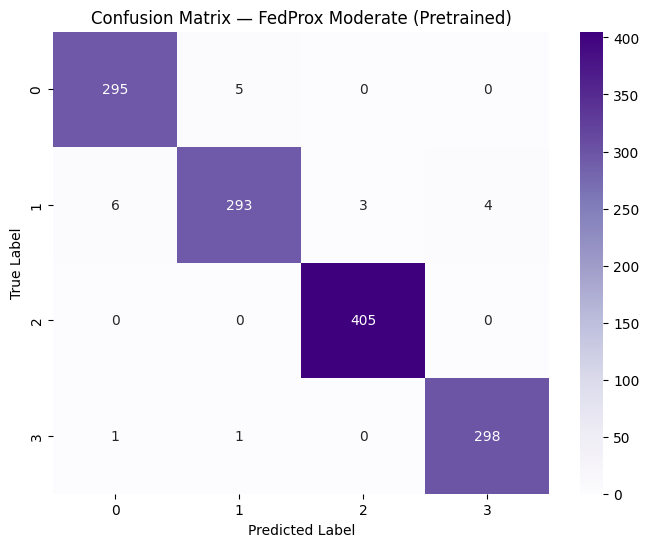

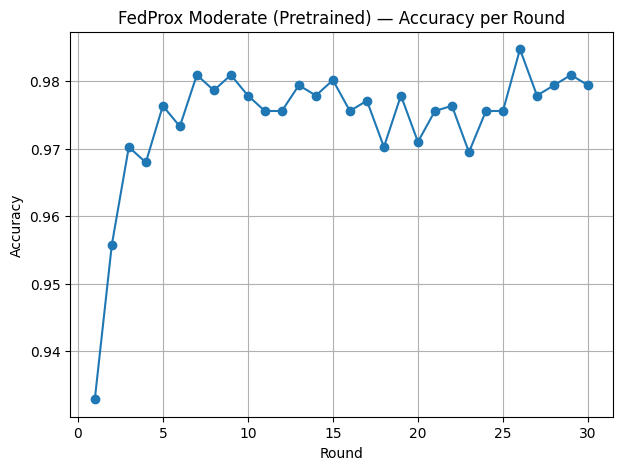

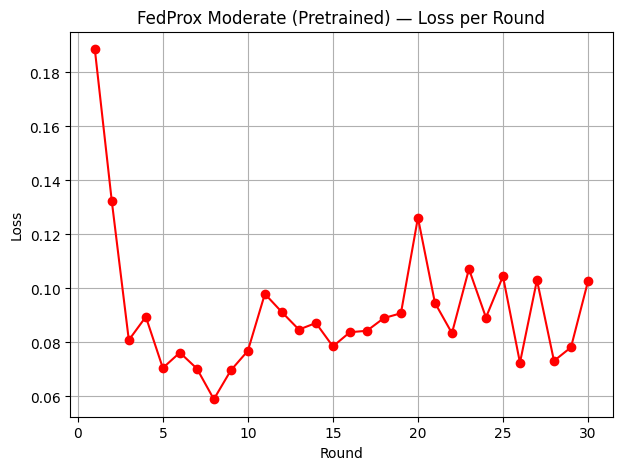

In [14]:
# ============================================================
#   EVALUATION — FEDPROX (MODERATE NON-IID, PRETRAINED)
# ============================================================

import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
from torchvision import models
import torch.nn as nn


# ============================================================
# DEVICE
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("DEVICE =", DEVICE)


# ============================================================
# MODEL DEF — must match training EXACTLY
# ============================================================
def create_pretrained_resnet18_mod_fp(num_classes):

    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze early layers
    for p in model.conv1.parameters(): p.requires_grad = False
    for p in model.bn1.parameters(): p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    # Train deeper layers
    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    # Replace FC head
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)

    return model


# ============================================================
# LOAD BEST FEDPROX PRETRAINED MODEL
# ============================================================
NUM_CLASSES_MOD = len(train_dataset.classes)

best_model_fp = create_pretrained_resnet18_mod_fp(NUM_CLASSES_MOD)
best_model_fp.load_state_dict(torch.load("best_fedprox_moderate_pretrained.pth", map_location=DEVICE))
best_model_fp.to(DEVICE)
best_model_fp.eval()

print("✅ Loaded: best_fedprox_moderate_pretrained.pth")


# ============================================================
# HOLDOUT EVALUATION
# ============================================================
crit_ce = nn.CrossEntropyLoss()

all_preds = []
all_labels = []
total_loss = 0
total = 0

with torch.no_grad():
    for x, y in holdout_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        logits = best_model_fp(x)
        loss = crit_ce(logits, y)

        total_loss += loss.item() * x.size(0)
        total += x.size(0)

        preds = logits.argmax(1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

loss = total_loss / total
acc = (all_preds == all_labels).mean()
precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

print("\n📊 FEDPROX — MODERATE NON-IID (PRETRAINED) METRICS")
print(f"Accuracy : {acc:.4f}")
print(f"Loss     : {loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


# ============================================================
# CONFUSION MATRIX
# ============================================================
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix — FedProx Moderate (Pretrained)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# ============================================================
# LOAD METRICS HISTORY (SAVED DURING TRAINING)
# ============================================================
history_fp = np.load("metrics_history_fedprox_moderate_pretrained.npy", allow_pickle=True).item()

rounds = history_fp["round"]
accs = [m["acc"] for m in history_fp["holdout"]]
losses = [m["loss"] for m in history_fp["holdout"]]


# ============================================================
# ACCURACY PLOT
# ============================================================
plt.figure(figsize=(7,5))
plt.plot(rounds, accs, marker="o")
plt.title("FedProx Moderate (Pretrained) — Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


# ============================================================
# LOSS PLOT
# ============================================================
plt.figure(figsize=(7,5))
plt.plot(rounds, losses, marker="o", color="red")
plt.title("FedProx Moderate (Pretrained) — Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


DEVICE: mps

====== FedAvg Moderate Results ======
acc: 0.9825
loss: 0.0790
precision: 0.9814
recall: 0.9812
f1: 0.9813

====== FedProx Moderate Results ======
acc: 0.9847
loss: 0.0725
precision: 0.9840
recall: 0.9835
f1: 0.9838


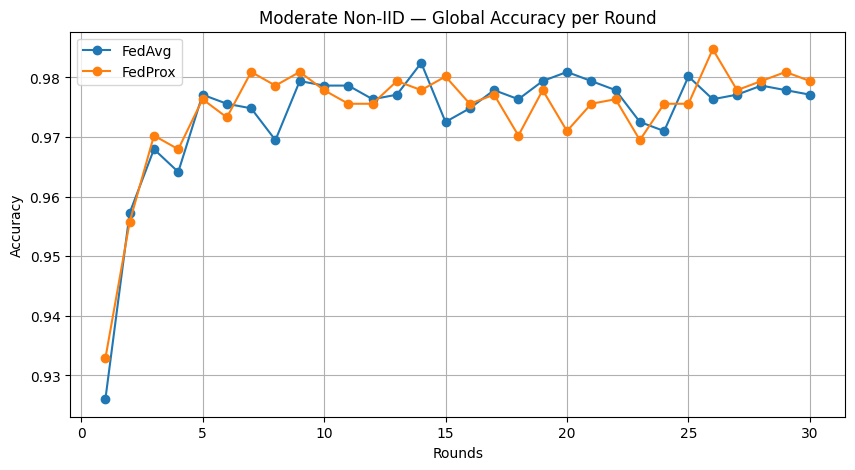

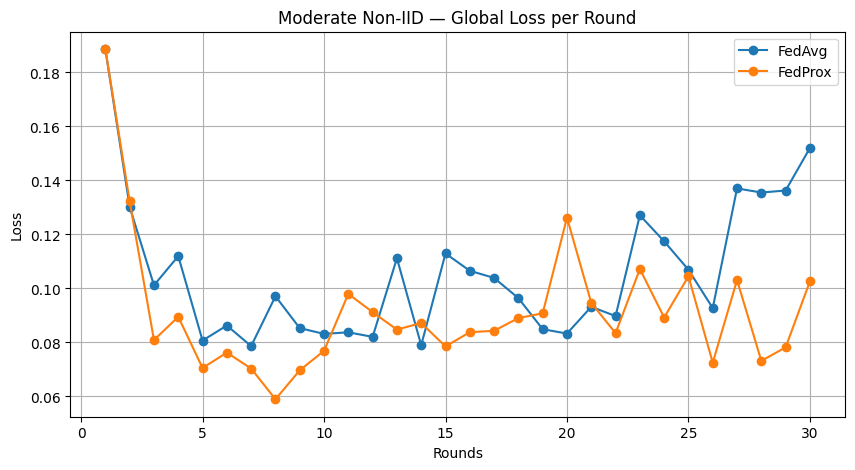

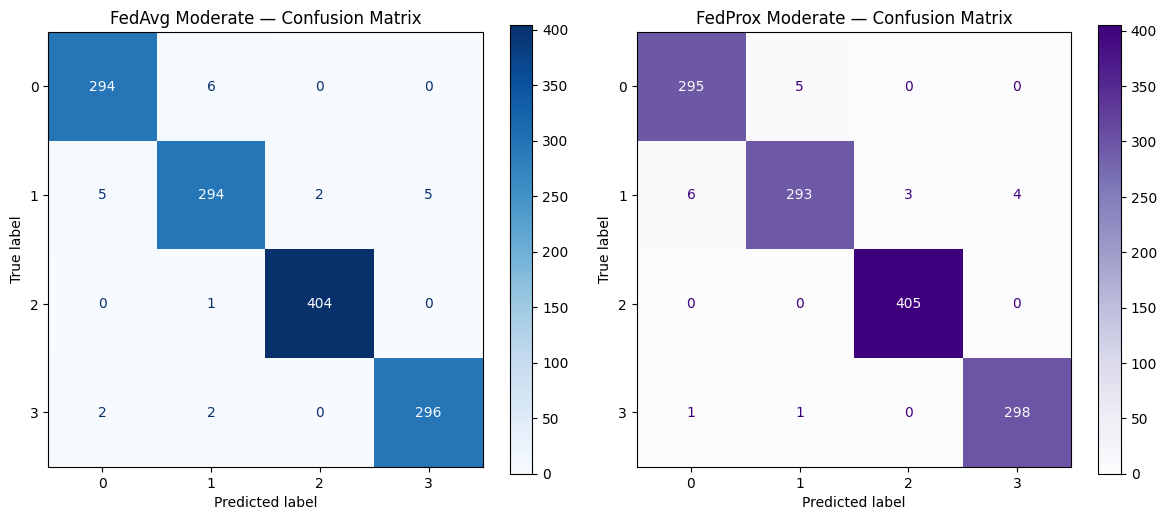

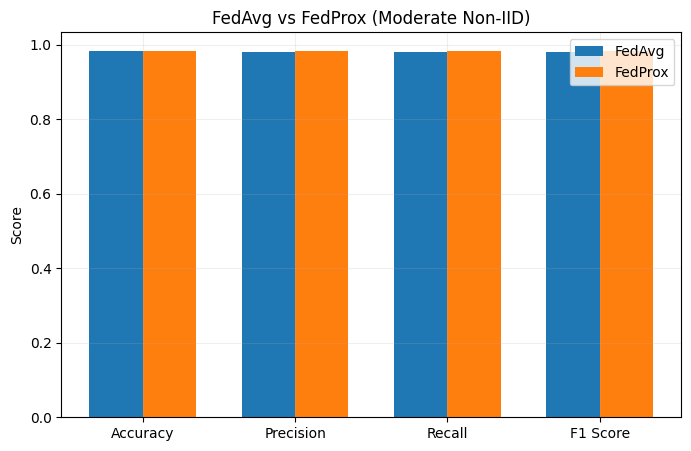

In [15]:
# ============================================================
#  FEDAVG vs FEDPROX — MODERATE NON-IID (PRETRAINED RESNET18)
# ============================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score
)
import seaborn as sns
import torch.nn as nn
from torchvision import models

# Device ------------------------------------------------------
DEVICE = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")
print("DEVICE:", DEVICE)

# ============================================================
#   MODEL BUILDER — must match training
# ============================================================
def create_pretrained_resnet18_mod(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze earlier layers
    for p in model.conv1.parameters(): p.requires_grad = False
    for p in model.bn1.parameters(): p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    # Train deeper layers
    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    # Replace classifier
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)

    return model


# ============================================================
#     LOAD METRICS HISTORY
# ============================================================
fedavg_hist = np.load("metrics_history_fedavg_moderate_pretrained.npy",
                      allow_pickle=True).item()
fedprox_hist = np.load("metrics_history_fedprox_moderate_pretrained.npy",
                       allow_pickle=True).item()

# Extract round-wise accuracy/loss
rounds_fa = fedavg_hist["round"]
acc_fa = [m["acc"] for m in fedavg_hist["holdout"]]
loss_fa = [m["loss"] for m in fedavg_hist["holdout"]]

rounds_fp = fedprox_hist["round"]
acc_fp = [m["acc"] for m in fedprox_hist["holdout"]]
loss_fp = [m["loss"] for m in fedprox_hist["holdout"]]


# ============================================================
#     LOAD TRAINED MODELS
# ============================================================
NUM_CLASSES = len(train_dataset.classes)

fedavg_model = create_pretrained_resnet18_mod(NUM_CLASSES).to(DEVICE)
fedavg_model.load_state_dict(torch.load("best_fedavg_moderate_pretrained.pth",
                                        map_location=DEVICE))
fedavg_model.eval()

fedprox_model = create_pretrained_resnet18_mod(NUM_CLASSES).to(DEVICE)
fedprox_model.load_state_dict(torch.load("best_fedprox_moderate_pretrained.pth",
                                         map_location=DEVICE))
fedprox_model.eval()

crit_ce = nn.CrossEntropyLoss()

# ============================================================
#         EVALUATION FUNCTION
# ============================================================
def evaluate_full(model, loader):
    model.eval()
    preds_all, labels_all = [], []
    total_loss = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = crit_ce(logits, y)

            total_loss += loss.item() * x.size(0)
            total += x.size(0)

            preds_all.append(logits.argmax(1).cpu())
            labels_all.append(y.cpu())

    preds_all = torch.cat(preds_all).numpy()
    labels_all = torch.cat(labels_all).numpy()

    return {
        "acc": (preds_all == labels_all).mean(),
        "loss": total_loss / total,
        "precision": precision_score(labels_all, preds_all, average="macro", zero_division=0),
        "recall": recall_score(labels_all, preds_all, average="macro", zero_division=0),
        "f1": f1_score(labels_all, preds_all, average="macro", zero_division=0),
        "preds": preds_all,
        "labels": labels_all
    }


# ============================================================
#          FINAL EVALUATION ON HOLDOUT
# ============================================================
fa_final = evaluate_full(fedavg_model, holdout_loader)
fp_final = evaluate_full(fedprox_model, holdout_loader)

print("\n====== FedAvg Moderate Results ======")
for k, v in fa_final.items():
    if k not in ("preds", "labels"):
        print(f"{k}: {v:.4f}")

print("\n====== FedProx Moderate Results ======")
for k, v in fp_final.items():
    if k not in ("preds", "labels"):
        print(f"{k}: {v:.4f}")


# ============================================================
#     📈 ACCURACY & LOSS PLOTS
# ============================================================
plt.figure(figsize=(10,5))
plt.plot(rounds_fa, acc_fa, marker='o', label="FedAvg")
plt.plot(rounds_fp, acc_fp, marker='o', label="FedProx")
plt.title("Moderate Non-IID — Global Accuracy per Round")
plt.xlabel("Rounds"); plt.ylabel("Accuracy")
plt.grid(); plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(rounds_fa, loss_fa, marker='o', label="FedAvg")
plt.plot(rounds_fp, loss_fp, marker='o', label="FedProx")
plt.title("Moderate Non-IID — Global Loss per Round")
plt.xlabel("Rounds"); plt.ylabel("Loss")
plt.grid(); plt.legend()
plt.show()


# ============================================================
#      🤝 CONFUSION MATRICES (SIDE BY SIDE)
# ============================================================
cm_fa = confusion_matrix(fa_final["labels"], fa_final["preds"])
cm_fp = confusion_matrix(fp_final["labels"], fp_final["preds"])

fig, ax = plt.subplots(1, 2, figsize=(12,5))

ConfusionMatrixDisplay(cm_fa).plot(ax=ax[0], cmap="Blues")
ConfusionMatrixDisplay(cm_fp).plot(ax=ax[1], cmap="Purples")

ax[0].set_title("FedAvg Moderate — Confusion Matrix")
ax[1].set_title("FedProx Moderate — Confusion Matrix")

plt.tight_layout()
plt.show()


# ============================================================
#     📊 BAR PLOT (ACC, PRECISION, RECALL, F1)
# ============================================================
labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
fa_vals = [fa_final["acc"], fa_final["precision"], fa_final["recall"], fa_final["f1"]]
fp_vals = [fp_final["acc"], fp_final["precision"], fp_final["recall"], fp_final["f1"]]

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - w/2, fa_vals, w, label="FedAvg")
plt.bar(x + w/2, fp_vals, w, label="FedProx")

plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("FedAvg vs FedProx (Moderate Non-IID)")
plt.legend()
plt.grid(alpha=0.2)
plt.show()
